In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
import copy 
from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    err = np.std(delta)
    indx, = np.where(np.abs(delta)<0.6)
    y = y_trn[indx]-p_y_trn[indx]
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.sqrt(np.median(y**2)), fontsize=16, color='k')
    
    delta = y_cvl-p_y_cvl
    err = np.std(delta)
    indx, = np.where(np.abs(delta)<0.6)
    y = y_cvl[indx]-p_y_cvl[indx]    
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.sqrt(np.median(y**2)), fontsize=16, color='k')
    
    delta = y_tst-p_y_tst
    err = np.std(delta)
    indx, = np.where(np.abs(delta)<0.6)
    y = y_tst[indx]-p_y_tst[indx]    
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.sqrt(np.median(y**2)), fontsize=16, color='k')
    
    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=16)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 


    fig.savefig(plotName+".png")
    plt.show()
#######################################

## loading data
inFile = '../reddening/ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

Feature Importances:  [0.05230735 0.03904499 0.0742716  0.83437606]
g_r 	-->  5.23%
r_i 	-->  3.90%
i_z 	-->  7.43%
pc0 	-->  83.44%


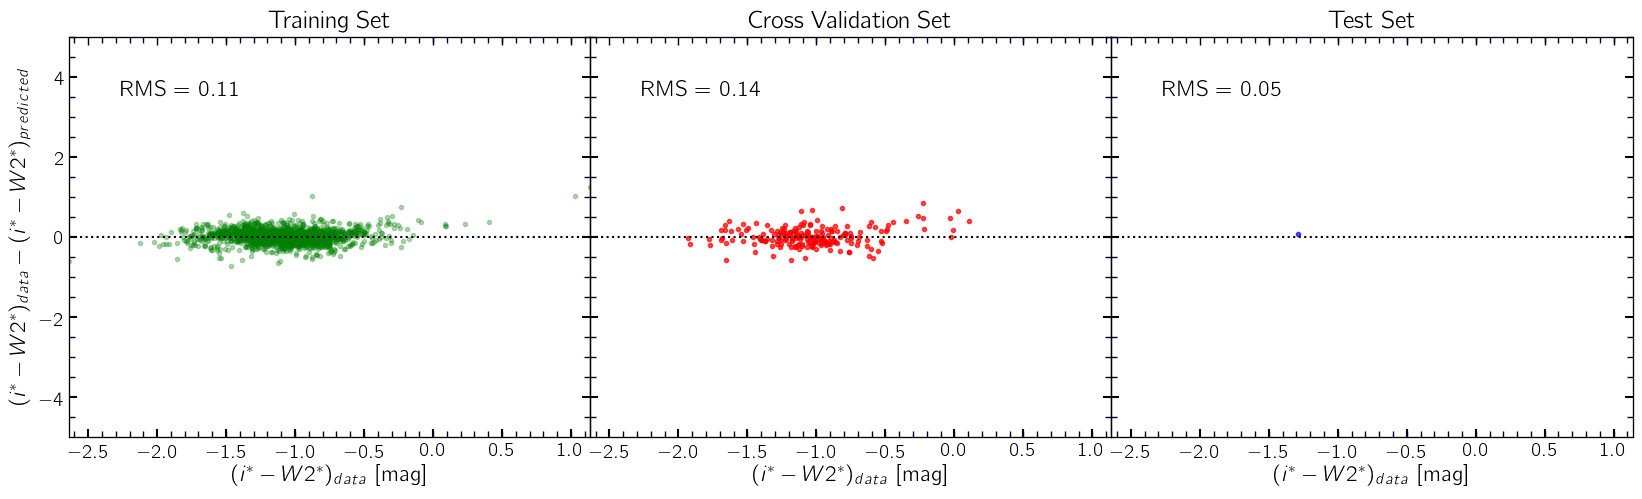

In [3]:
## Sample management
## table_tst: Test table
## table_cvl: Cross Validation table
## table_trn: Training Table
## N_test: Number of test data points
## N_cross: Number of cross validation data points
## Seed_test: Random seed number to choose the test sample (i.e. fixed=0)
## Seed_cross: Random seed number to choose the cross validation sample 
##                     (can be changed to see the algorithm performance)
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=20, N_cross=200, N_test=1)
import pylab as py

################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'i_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=10
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i^*-W2^*'
text_unit = 'mag'
x0 = np.min(table_trn[output])
x1 = np.max(table_trn[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-5,5]



d = np.abs(p_y_trn-y_trn)
tt = 0.6
indx, = np.where(d<tt)
X = y_trn[indx]
Xp = p_y_trn[indx]
Y = X-Xp
m, b = np.polyfit(X,Y, 1)
p_y_trn = (p_y_trn+b)/(1-m)
p_y_cvl = (p_y_cvl+b)/(1-m)
p_y_tst = (p_y_tst+b)/(1-m)


makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='temp')

0.08716252054273155 0.1502105244198982 -0.010219689766840956
0.1072258885196763 0.17095806906749847 -0.0035106734941408035


(-3, 3)

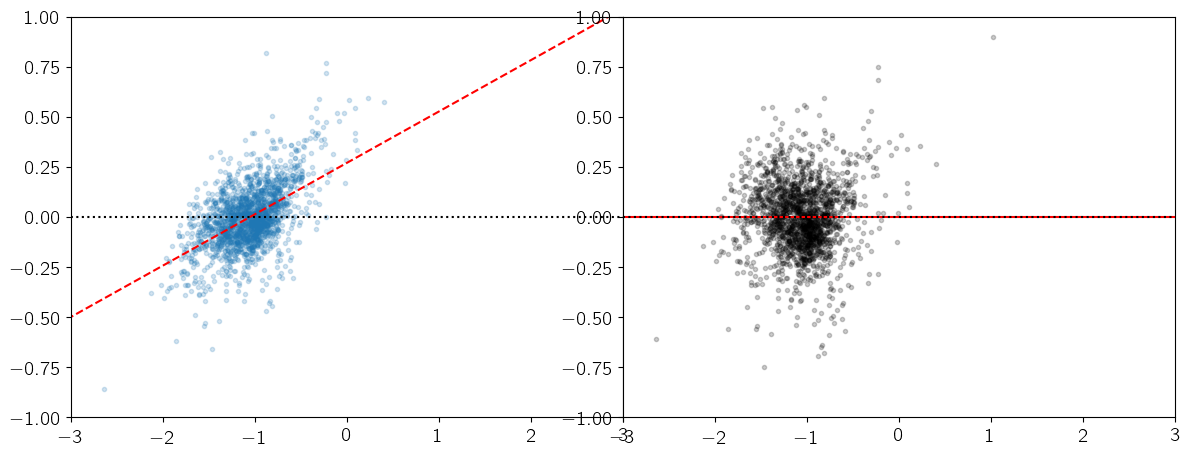

In [4]:
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'i_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=10
bootstrap=True
################################ Regression (Random Forest)

regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, \
        max_features=max_features, min_samples_leaf=min_samples_leaf, \
            bootstrap=bootstrap)

table_all = prepareSamples(table, noTest=True)
x_all, y_all = ML_data(table_all, features, output)
regr.fit(x_all, y_all)
p_y_all  = regr.predict(x_all)

######################################
# fig = py.figure(figsize=(5, 5), dpi=100)  
# ax = fig.add_subplot(111)
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

x_ = np.linspace(-10,10.0,50)
d = np.abs(p_y_all-y_all)
tt = 0.6
indx, = np.where(d<tt)
X = y_all[indx]
Xp = p_y_all[indx]
Y = X-Xp
m, b = np.polyfit(X,Y, 1)
ax1.plot(y_all,y_all-p_y_all, '.', alpha=0.2)
p_y_all = (p_y_all+b)/(1-m)
##p_y_all = p_y_all+m*((p_y_all+b)/(1-m))+b
######################################
print np.sqrt(np.median(Y**2)), np.std(Y), np.median(Y)

ax2.plot(y_all,y_all-p_y_all, 'k.', alpha=0.2)


Xp = (Xp+b)/(1.-m)
Y = X-Xp
m0, b0 = np.polyfit(X,Y, 1)
ax2.plot(x_, m0*x_+b0, 'r-')
ax1.plot(x_, m*x_+b, 'r--')

ax1.plot(x_, 0*x_, 'k:')
ax2.plot(x_, 0*x_, 'k:')
print np.sqrt(np.median(Y**2)), np.std(Y), np.median(Y)
ax1.set_ylim(-1,1)
ax1.set_xlim(-3,3)
ax2.set_ylim(-1,1)
ax2.set_xlim(-3,3)


1154 68 -0.773 14.521842167446126
48 14.612216214284153 [-3.07543135e-05]
Delta W: 0.09
-0.005010598757284823
-0.004558390233547982
-0.003997992049712462
-0.0031074891344202438


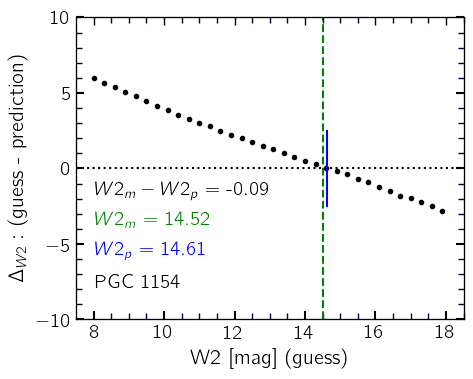

In [8]:
j = 80
PGC = table_all['pgc'][j]
W2  = table_all['w2'][j]
INC = table_all["inc"][j]
P0  = table_all["pc0"][j]
M21 = table_all["m21"][j]
M0  = table_all["logWimx"][j]
WBA = table_all["Wba"][j]
R50 = table_all["R50_w2"][j]
print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_all, regr, features, output, index=j) # , m=m, b=b)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')


ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_ylim([-10,10])
xlim = ax.get_xlim()
ylim = ax.get_ylim()

set_axes([ax], xlim, ylim)


x0 = 0.95*xlim[0]+0.05*xlim[1]
y0 = 0.9*ylim[0]+0.1*ylim[1]
ax.text(x0,y0, 'PGC '+'%d'%PGC, fontsize=14, color='k')


ax.set_xlabel('W2 [mag] (guess)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (guess - prediction)', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    
    
    x0 = 0.95*xlim[0]+0.05*xlim[1]
    y0 = 0.6*ylim[0]+0.40*ylim[1]
    ax.text(x0,y0, r'$W2_m-W2_p$'+' = '+'%.2f'%(W2-w2p), fontsize=14, color='k')
    y0 = 0.7*ylim[0]+0.30*ylim[1]
    ax.text(x0,y0, r'$W2_m$'+' = '+'%.2f'%(W2), fontsize=14, color='green')
    y0 = 0.8*ylim[0]+0.20*ylim[1]
    ax.text(x0,y0, r'$W2_p$'+' = '+'%.2f'%w2p, fontsize=14, color='blue')    
    
    
    
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'b-') 


In [7]:
W2_lst = []
w2p_lst = []

for j in range(len(table_all['pgc'])):
    
    PGC = table_all['pgc'][j]
    W2  = table_all['w2'][j]
    INC = table_all["inc"][j]
    P0  = table_all["pc0"][j]
    M21 = table_all["m21"][j]
    M0  = table_all["logWimx"][j]
    WBA = table_all["Wba"][j]
    R50 = table_all["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_all, regr, features, output, index=j)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst.append(W2)
        w2p_lst.append(w2p)
    ###############################################
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)

Not solvable ... !!!


In [8]:
W2_lst0 = []
w2p_lst0 = []

for j in range(len(table_all['pgc'])):
    
    PGC = table_all['pgc'][j]
    W2  = table_all['w2'][j]
    INC = table_all["inc"][j]
    P0  = table_all["pc0"][j]
    M21 = table_all["m21"][j]
    M0  = table_all["logWimx"][j]
    WBA = table_all["Wba"][j]
    R50 = table_all["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_all, regr, features, output, index=j,m=m,b=b)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst0.append(W2)
        w2p_lst0.append(w2p)
    ###############################################
W2_lst0 = np.asarray(W2_lst0)
w2p_lst0 = np.asarray(w2p_lst0)

Not solvable ... !!!
Not solvable ... !!!
Not solvable ... !!!


0.2950555943614524
0.23697514957381036


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'100'),
 Text(0,0,'200'),
 Text(0,0,'300'),
 Text(0,0,'400'),
 Text(0,0,'500')]

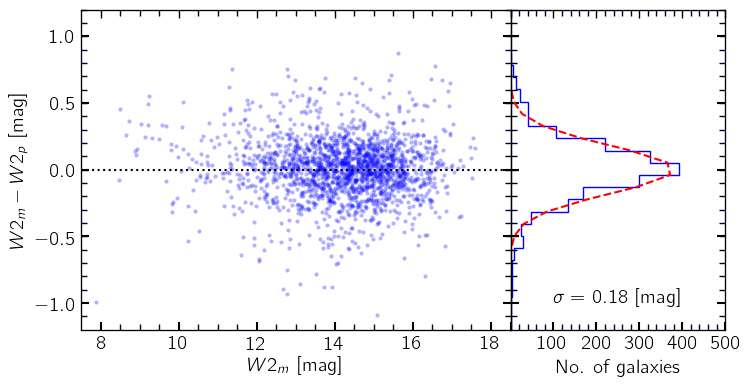

In [134]:
fig = py.figure(figsize=(7, 4), dpi=100)  
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
# ax.plot(W2_lst0, W2_lst0-w2p_lst0, 'r.', alpha=0.2)
ax.plot(W2_lst, W2_lst-w2p_lst, 'bo', alpha=0.3, fillstyle='full', markersize=3, markeredgewidth=0)


ax.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [7.5,18.5], [-1.2,1.2])

rms0 = np.sqrt(np.mean((W2_lst0-w2p_lst0)**2))
rms  = np.sqrt(np.mean((W2_lst-w2p_lst)**2))

# W2_lst_ = np.concatenate((W2_lst0,W2_lst))
# w2p_lst_ = np.concatenate((w2p_lst0,w2p_lst))



print rms0
print rms


n, bins, patches = ax_.hist(W2_lst-w2p_lst, bins=30, orientation="horizontal",histtype='step', color='b')
set_axes([ax_], [0,500], [-1.2,1.2])
plt.setp(ax_.get_yticklabels(), visible=False)

import matplotlib.mlab as mlab
XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<0.5)]
mu = 0
sigma = np.std(XX)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax_.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax_.text(100,-1, r'$\sigma =$'+' %.2f'%sigma+' [mag]', fontsize=14, color='k')
ax_.set_xlabel('No. of galaxies', fontsize=14)
a=ax_.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax_.set_xticklabels(a)